## AIDA reactive experiments

In [1]:
using Revise
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra
import ProgressMeter
using WAV
using Plots

┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1317


In [3]:
include("helpers/aida_segmentation.jl")
include("helpers/aida_snr.jl")
include("helpers/aida_ar.jl")
include("models_inferences.jl")

batch_coupled_learning (generic function with 1 method)

### Simple LAR model to infer parameters of audio signal

In [4]:
# load clean speech
cl, fs = wavread("sound/speech/sp02.wav");
cl_seg = get_frames(cl, fs);

In [4]:
cl_seg = get_frames(cl, fs)
cmx, cvx, cmθ, cvθ, cγ = lar_batch_learning(cl_seg, 10, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


In [5]:
# load bar sound
br, fs = wavread("sound/environment/bar.wav");

In [6]:
br_seg = get_frames(br, fs)
bmx, bvx, bmθ, bvθ, bγ = lar_batch_learning(br_seg, 2, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


In [7]:
mean(bmθ, dims=1)

1×2 Matrix{Float64}:
 1.25062  -0.422882

In [8]:
bγ[end][1]/bγ[end][2]

80180.69455973615

In [9]:
x, γ, fe = inference_gaussian(reshape(br, (size(br, 1), )), 100)
mx, vx = mean(x), cov(x)
mγ = mean(γ)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


1.2247448686871407

In [13]:
ar_order = 5
from = 1
to = 1000
inputs, outputs = ar_ssm(br[from:1:to], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


[1.2072635491884685, -0.29810233212581544, 0.01621429606547778, -0.26231882298961373, 0.1798779456337456]	492.84051960365116


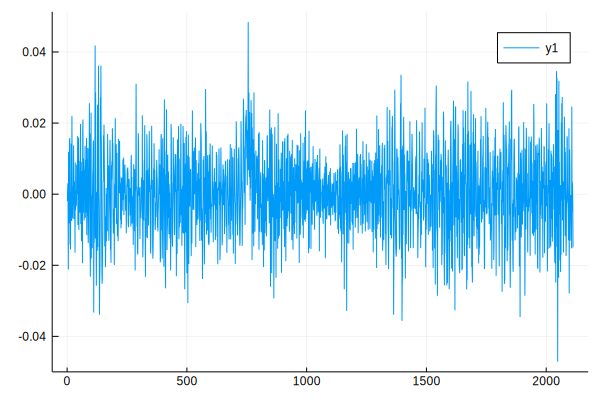

In [14]:
plot(br[1:10:end])

In [18]:
# load kids sound
kr, fs = wavread("sound/environment/kids_old.wav");

In [20]:
kr_seg = get_frames(kr, fs)
kmx, kvx, kmθ, kvθ, kγ = lar_batch_learning(kr_seg, 2, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


In [21]:
x, γ, fe = inference_gaussian(reshape(kr, (size(kr, 1), )), 100)
mx, mx = mean(x), cov(x)
mγ = mean(γ)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


1.224744867879589

In [22]:
ar_order = 10
from = 1
to = 1000
inputs, outputs = ar_ssm(kr[from:1:to], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


[1.7165319559487267, -1.64270847035433, 0.802828694609524, -0.33360693559957255, 0.35995451371455345, -0.5373125263912328, 0.32263370988818707, 0.10161316241022789, -0.41096272296658665, 0.3107576822568615]	445.96526744163975


In [24]:
# load forest sound
fr, fs = wavread("sound/environment/forest_old.wav");

In [26]:
fr_seg = get_frames(fr, fs)
frmx, frvx, frmθ, frvθ, frγ = lar_batch_learning(fr_seg, 5, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


In [27]:
ar_order = 2
inputs, outputs = ar_ssm(fr[1:10:end], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress: 100%|█████████████████████████████████████████| Time: 0:03:10


[0.8736889491613922, -0.1749365872955999]	957.349073007666


In [72]:
ar_order = 2
inputs, outputs = ar_ssm(fr[1:100:end], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[-0.20323649754037096, -0.13362197085378788]	102.9944354972934


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [7]:
# train sound
tr, fs = wavread("sound/environment/train.wav")

([0.003204443494979705; 3.051850947599719e-5; … ; -0.007019257179479354; 0.0022583697012237922], 8000.0f0, 0x0010, WAVChunk[WAVChunk(Symbol("fmt "), UInt8[0x10, 0x00, 0x00, 0x00, 0x01, 0x00, 0x01, 0x00, 0x40, 0x1f, 0x00, 0x00, 0x80, 0x3e, 0x00, 0x00, 0x02, 0x00, 0x10, 0x00]), WAVChunk(:LIST, UInt8[0x49, 0x4e, 0x46, 0x4f, 0x49, 0x4e, 0x41, 0x4d, 0x08, 0x00  …  0x73, 0x70, 0x65, 0x63, 0x74, 0x6f, 0x72, 0x4a, 0x00, 0x00]), WAVChunk(Symbol("id3 "), UInt8[0x49, 0x44, 0x33, 0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x26  …  0x07, 0x00, 0x00, 0x00, 0x38, 0x2e, 0x38, 0x2e, 0x31, 0x37])])

In [8]:
tr_seg = get_frames(tr, fs)
trmx, trvx, trmθ, trvθ, trγ = lar_batch_learning(tr_seg, 2, 10, 1e-12);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


In [9]:
mean(trmθ, dims=1)

1×2 Matrix{Float64}:
 1.04455  -0.196975

In [10]:
trγ[end][1]/trγ[end][2]

34007.7061427125

In [82]:
ar_order = 10
inputs, outputs = ar_ssm(tr[1:10:end], ar_order)
γ, θ, fe = inference_ar(inputs, outputs, ar_order, 10)
println(mean(θ), "\t", mean(γ))

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:00

[0.05580275684828447, -0.06971276403550794, 0.03605368101506624, -0.12498182953809668, -0.0849619878863063, 0.10622721636016212, 0.15419279043573297, -0.04245459143726561, -0.16477088656525696, 0.07056581449065422]	92.28078085307476


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


# Mixed sounds

In [12]:
# load mixed scene
bob, fs = wavread("sound/mixed/bar_speech.wav")
# plot(bob)
bob_seg = get_frames(bob, fs, len_sec=0.01, overlap_sec=0.002);

In [7]:
bobmx, bobvx, bobmθ, bobvθ, bobγ = lar_batch_learning(bob_seg, 10, 10, 1e-3);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


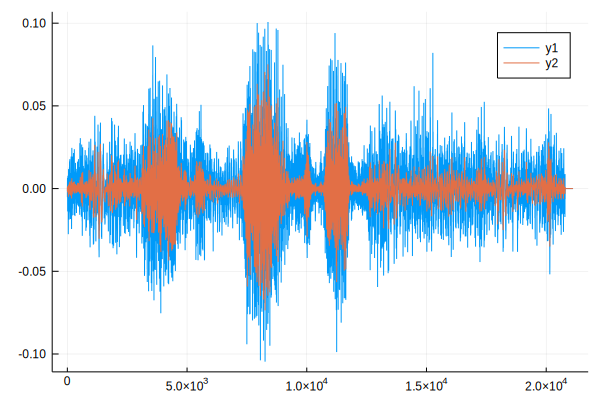

In [8]:
plot(get_signal(bob_seg, fs, len_sec=0.01, overlap_sec=0.002))
plot!(get_signal(bobmx, fs, len_sec=0.01, overlap_sec=0.002))

## Coupled model (AR speech + AR noise)

In [9]:
# obtaining prior for BAR
totseg = 352
ar_order = 2
rmθ = zeros(totseg, ar_order)
rvθ = zeros(totseg, ar_order, ar_order)
for segnum in 1:totseg
    rmθ[segnum, :], rvθ[segnum, :, :] = reshape(mean(bmθ, dims=1), (ar_order,)), mean(bvθ, dims=1)[1, :, :]
end
priors_eta = rmθ, rvθ
priors_tau = [(bγ[end][1], bγ[end][2]) for _ in 1:352]

LoadError: UndefVarError: bmθ not defined

In [13]:
# obtaining prior for TRAIN
totseg = 352
ar_order = 2
rmθ = zeros(totseg, ar_order)
rvθ = zeros(totseg, ar_order, ar_order)
for segnum in 1:totseg
    rmθ[segnum, :], rvθ[segnum, :, :] = reshape(mean(trmθ, dims=1), (ar_order,)), mean(trvθ, dims=1)[1, :, :]
end
priors_eta = rmθ, rvθ
priors_tau = [(trγ[end][1], trγ[end][2]) for _ in 1:352]

352-element Vector{Tuple{Float64, Float64}}:
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 ⋮
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)
 (41.0, 0.0012056091001240868)

In [36]:
# get time-varying priors from lar inference
priors_eta = (bmθ, bvθ[:, :, :])
priors_tau = bγ

352-element Vector{Tuple{Float64, Float64}}:
 (41.0, 0.0007277968753535233)
 (41.0, 0.0008015752801382323)
 (41.0, 0.0005614628201809478)
 (41.0, 0.0005934365347512152)
 (41.0, 0.0007842651406818357)
 (41.0, 0.0006508027537904813)
 (41.0, 0.000529154321029808)
 (41.0, 0.00043520054475210454)
 (41.0, 0.0006221654509123437)
 (41.0, 0.0008363201619183917)
 (41.0, 0.0007484915700542461)
 (41.0, 0.0006760581343009572)
 (41.0, 0.0007149932319424159)
 ⋮
 (41.0, 0.0006413774740689301)
 (41.0, 0.001077113428868207)
 (41.0, 0.0011437694007727776)
 (41.0, 0.001447737184713328)
 (41.0, 0.0014671278237948073)
 (41.0, 0.0012339770100812158)
 (41.0, 0.0007528525017637935)
 (41.0, 0.0007545476890029288)
 (41.0, 0.0007814370684190937)
 (41.0, 0.0008573882415837178)
 (41.0, 0.0007043532537280813)
 (41.0, 0.0005113450341772011)

In [10]:
totseg = 352
ar_order = 2
rmθ = zeros(totseg, ar_order)
rvθ = zeros(totseg, ar_order, ar_order)
for segnum in 1:totseg
    rmθ[segnum, :], rvθ[segnum, :, :] = mean(θ), cov(θ)
end
priors_eta = rmθ, rvθ
priors_tau = [params(γ) for _ in 1:352]

LoadError: UndefVarError: θ not defined

In [14]:
speech_bar, fs = wavread("sound/mixed/train_speech.wav")
sb_seg = get_frames(speech_bar, fs)
rmz, rvz, rmθ, rvθ, rγ, rmx, rvx, rmη, rvη, rτ, fe = batch_coupled_learning(sb_seg, priors_eta, priors_tau, 10, 2, 10);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:41


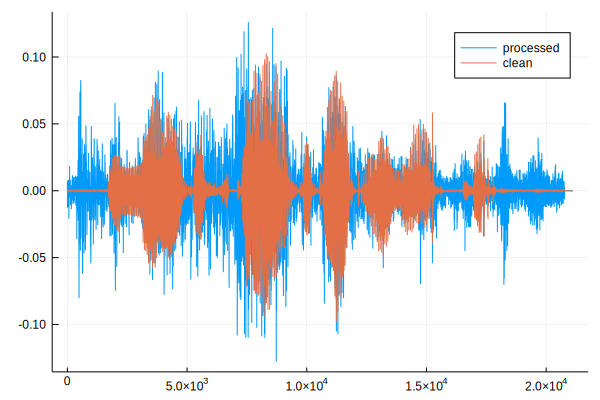

In [16]:
plot(get_signal(rmz, fs), label=:processed)
plot!(get_signal(cl_seg, fs), label=:clean)

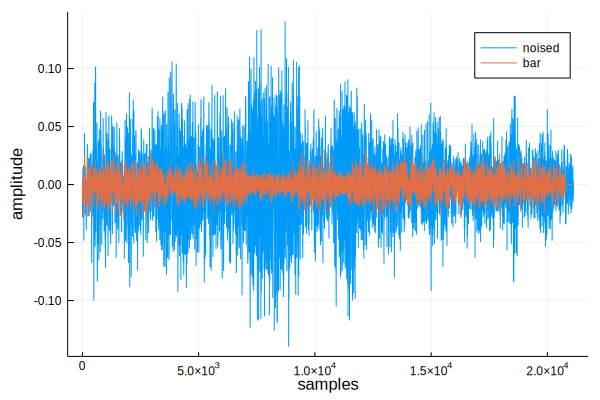

In [17]:
plot(speech_bar, label=:noised)
plot!(get_signal(rmx, fs), label=:bar, ylabel="amplitude", xlabel="samples")

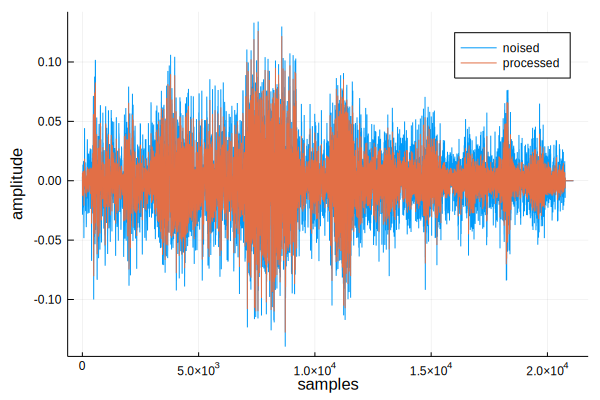

In [18]:
plot(get_signal(sb_seg, fs), label=:noised, ylabel="amplitude", xlabel="samples")
plot!(get_signal(rmz, fs), label=:processed)
# xlims!(5000,5100)

In [19]:
wavwrite(get_signal(rmz, fs), fs, "sound/processed/reconstructed_speech_.wav")

In [20]:
wavwrite(get_signal(rmx, fs), fs, "sound/processed/reconstructed_train.wav")

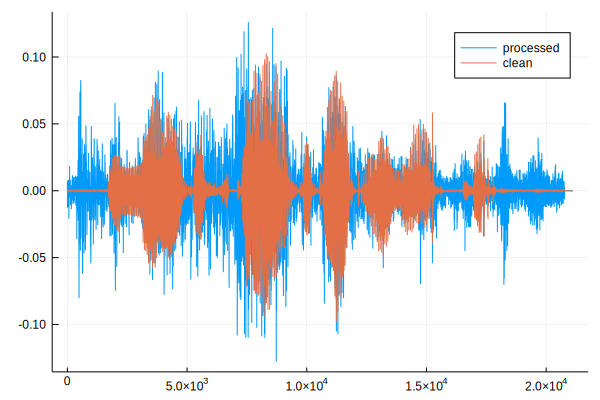

In [21]:
plot(get_signal(rmz, fs), label="processed")
plot!(get_signal(cl_seg, fs), label="clean")
# plot!(get_signal(rmx, fs))

In [22]:
# load clean speech
cl, fs = wavread("sound/speech/sp02.wav");
cl_seg = get_frames(cl, fs)

352×80 Matrix{Float64}:
  0.000305185   0.000335704   0.000183111  …  -0.000152593   6.1037e-5
  0.000305185  -0.000183111   0.0             -0.000152593   9.15555e-5
  3.05185e-5    3.05185e-5    6.1037e-5        0.000122074  -0.000122074
  3.05185e-5   -0.000152593   0.0              6.1037e-5     9.15555e-5
  0.0           0.00021363   -0.000152593      3.05185e-5    0.0
  6.1037e-5    -9.15555e-5    6.1037e-5    …   6.1037e-5     0.0
  3.05185e-5   -9.15555e-5    0.0             -0.000244148  -0.00021363
 -0.000122074  -9.15555e-5    0.000152593      0.0           6.1037e-5
 -3.05185e-5    9.15555e-5   -0.000122074      6.1037e-5     0.000183111
  0.000122074  -3.05185e-5    0.000183111     -0.000183111   6.1037e-5
  3.05185e-5    0.00021363    3.05185e-5   …   3.05185e-5   -0.00021363
 -3.05185e-5   -0.000183111  -0.000152593      0.0           0.0
  3.05185e-5   -0.000244148  -3.05185e-5      -0.000122074   9.15555e-5
  ⋮                                        ⋱                
 

In [23]:
snr_before = SNR(get_signal(cl_seg, fs), get_signal(sb_seg, fs))

-4.861098381352319

In [24]:
snr_after = SNR(get_signal(cl_seg, fs), get_signal(rmz, fs))

-2.298617823909022

In [25]:
SNR_gain = snr_after - snr_before

2.5624805574432967